In [ ]:
!pip install yfinance cvxpy

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp

In [ ]:
df = yf.download('IBM', start="2021-01-01", end="2024-09-01")

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,IBM,IBM,IBM,IBM,IBM,IBM
Date,,,,,,
2021-01-04 00:00:00+00:00,98.824783,118.489487,120.382408,117.629066,120.315491,5417443
2021-01-05 00:00:00+00:00,100.578979,120.592735,121.108986,119.130020,119.512428,6395872
2021-01-06 00:00:00+00:00,103.090668,123.604210,126.080307,121.147224,121.319313,8322708
2021-01-07 00:00:00+00:00,102.851463,123.317398,124.722755,122.619499,124.321220,4714740
2021-01-08 00:00:00+00:00,102.484680,122.877632,123.632889,121.395790,122.915871,4891305


In [ ]:
df.isna().sum().sum()

0

In [ ]:
df.duplicated().sum()

0

# Реалізація моделі Монте-Карло

In [ ]:
last_price = df['Close'].iloc[0]

def monte_carlo_simulation(num_simulations=1000, num_days=256):
    returns = df['Close'].pct_change().dropna()
    mean_return = returns.mean()
    std_dev = returns.std()

    simulated_prices = np.zeros((num_days, num_simulations))

    for i in range(num_simulations):
        prices = [last_price]
        for _ in range(num_days):
            price = prices[-1] * (1 + np.random.normal(mean_return, std_dev))
            prices.append(price)
        simulated_prices[:, i] = np.array(prices[1:]).flatten()

    return simulated_prices

simulated_prices = monte_carlo_simulation(num_simulations=1000, num_days=256)

In [ ]:
print(simulated_prices)

[[117.45305036 116.20436892 118.42134013 ... 120.98079422 119.14789741
  120.42909767]
 [119.18292375 117.81368974 118.51186308 ... 124.96253573 118.21127971
  121.83451751]
 [117.64854166 114.94137756 117.87003692 ... 125.36050451 118.08807735
  120.9969523 ]
 ...
 [126.51266317 108.36331422 125.78094252 ... 132.4411004  141.39074487
  168.55900528]
 [127.18241879 105.49914298 123.53666681 ... 134.32451864 143.67214932
  169.42884348]
 [126.53510826 102.68924916 123.96230485 ... 138.9537882  143.92511154
  171.65842958]]


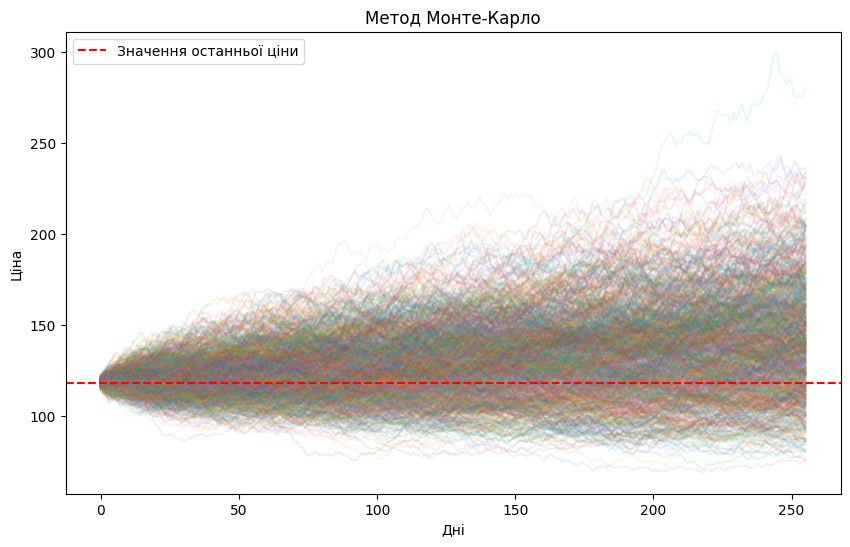

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(simulated_prices, alpha=0.1)
plt.title('Метод Монте-Карло')
plt.xlabel('Дні')
plt.ylabel('Ціна')
plt.axhline(y=last_price.item(), color='r', linestyle='--', label='Значення останньої ціни')
plt.legend()
plt.show()

In [ ]:
def calculate_risk_metrics(simulated_prices, confidence_level=0.95):

    last_simulated_prices = simulated_prices[-1, :]

    mean_future_price = np.mean(last_simulated_prices)
    variance = np.var(last_simulated_prices)
    var = np.percentile(last_simulated_prices, (1 - confidence_level) * 100)

    expected_shortfall = np.mean(last_simulated_prices[last_simulated_prices <= var])

    return {
        'mean_future_price': mean_future_price,
        'variance': variance,
        'VaR': var,
        'Expected Shortfall': expected_shortfall
    }

risk_metrics = calculate_risk_metrics(simulated_prices, confidence_level=0.95)


print(f"Середня майбутня ціна: {risk_metrics['mean_future_price']:.2f}")
print(f"Variance: {risk_metrics['variance']:.2f}")
print(f"Value at Risk (рівень 95%): {risk_metrics['VaR']:.2f}")
print(f"Expected Shortfall: {risk_metrics['Expected Shortfall']:.2f}")

Середня майбутня ціна: 141.51
Variance: 913.41
Value at Risk (рівень 95%): 96.44
Expected Shortfall: 89.16


# Валідація моделі

In [ ]:
historical_prices = df['Close'].values
normalized_historical_prices = historical_prices * (last_price.item() / historical_prices[0])
days_simulated = simulated_prices.shape[0]

In [ ]:
historical_returns = df['Close'].pct_change().dropna()
mean_historical_return = historical_returns.mean()
std_historical_return = historical_returns.std()
simulated_returns = np.diff(simulated_prices, axis=0) / simulated_prices[:-1, :]
mean_simulated_return = simulated_returns.mean()
std_simulated_return = simulated_returns.std()
print('\t Середня дохідність')
print(f"Історичні дані: {mean_historical_return}")
print(f"Симуляції: {mean_simulated_return}")
print('\t Стандартне відхилення')
print(f"Історичні дані: {std_historical_return}")
print(f"Симуляції: {std_simulated_return}")

	 Середня дохідність
Історичні дані: Ticker
IBM    0.000676
dtype: float64
Симуляції: 0.0006755114336244435
	 Стандартне відхилення
Історичні дані: Ticker
IBM    0.013804
dtype: float64
Симуляції: 0.013801066842925805


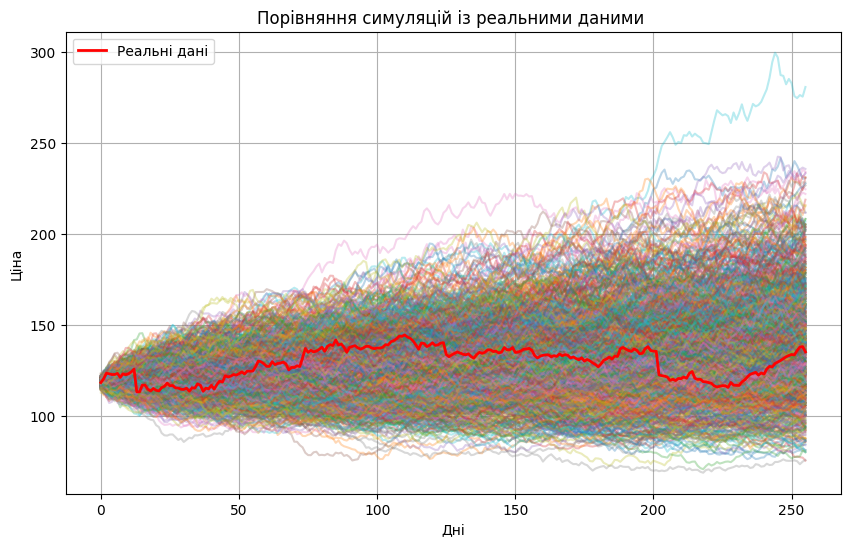

In [ ]:
def plot_simulations_vs_real_data(simulated_prices, normalized_historical_prices):
    days = simulated_prices.shape[0]

    plt.figure(figsize=(10, 6))

    for i in range(simulated_prices.shape[1]):
        plt.plot(simulated_prices[:, i], alpha=0.3)

    plt.plot(np.arange(len(normalized_historical_prices)), normalized_historical_prices, color='red', label='Реальні дані', linewidth=2)

    plt.title('Порівняння симуляцій із реальними даними ')
    plt.xlabel('Дні')
    plt.ylabel('Ціна')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_simulations_vs_real_data(simulated_prices, normalized_historical_prices[:days_simulated])

# Застосування в управлінні портфелем

In [ ]:
tickers = ['IBM', 'AAPL']
df = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Close']

returns = df.pct_change().dropna()
mean_returns = returns.mean()
std_dev = returns.std()
cov_matrix = returns.cov()

print("\nСередня прибутковість для IBM:", mean_returns['IBM'])
print("Середня прибутковість для AAPL:", mean_returns['AAPL'])
print("Стандартне відхилення для IBM:", std_dev['IBM'])
print("Стандартне відхилення для AAPL:", std_dev['AAPL'])
print("Ковариационная матрица:\n", cov_matrix)

[*********************100%***********************]  2 of 2 completed


Середня прибутковість для IBM: 0.0003852193715701823
Середня прибутковість для AAPL: 0.0011605951356745037
Стандартне відхилення для IBM: 0.017415401276937994
Стандартне відхилення для AAPL: 0.021147366556588595
Ковариационная матрица:
 Ticker      AAPL       IBM
Ticker                    
AAPL    0.000447  0.000162
IBM     0.000162  0.000303


In [ ]:
print("Коваріаційна матриця:\n", cov_matrix)

Коваріаційна матриця:
 Ticker      AAPL       IBM
Ticker                    
AAPL    0.000447  0.000162
IBM     0.000162  0.000303


In [ ]:
num_assets = len(tickers)
weights = cp.Variable(num_assets)

portfolio_return = mean_returns.values @ weights
portfolio_volatility = cp.quad_form(weights, cov_matrix)
constraints = [cp.sum(weights) == 1, weights >= 0]

target_return = 0.0007
constraints.append(portfolio_return >= target_return)
problem = cp.Problem(cp.Minimize(portfolio_volatility), constraints)
problem.solve()


optimal_weights = weights.value
print(f"Оптимальні ваги для акцій IBM і Apple: {optimal_weights}")

Оптимальні ваги для акцій IBM і Apple: [0.40597171 0.59402829]


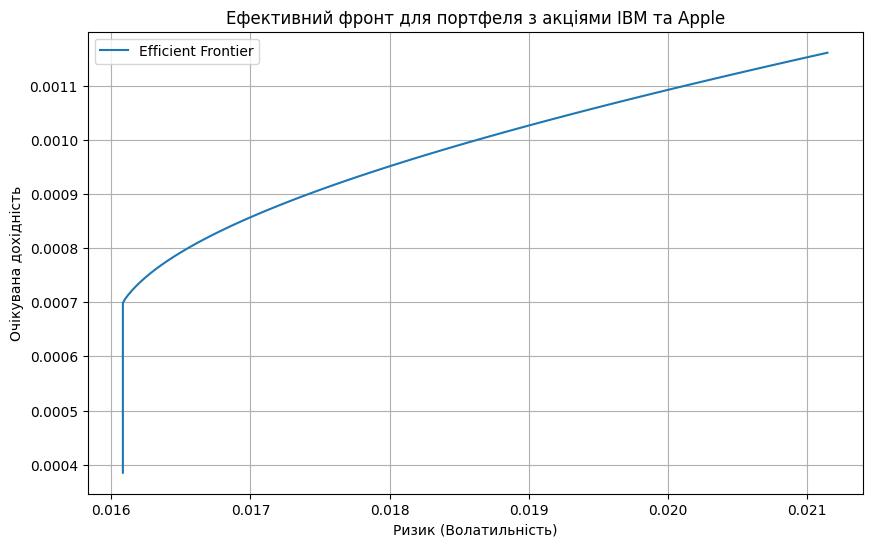

In [ ]:
target_returns_range = np.linspace(mean_returns.min(), mean_returns.max(), 100)
portfolio_volatilities = []

for r in target_returns_range:
    constraints[1] = portfolio_return >= r
    problem = cp.Problem(cp.Minimize(portfolio_volatility), constraints)
    problem.solve()
    portfolio_volatilities.append(np.sqrt(portfolio_volatility.value))

plt.figure(figsize=(10, 6))
plt.plot(portfolio_volatilities, target_returns_range, label='Efficient Frontier')
plt.xlabel('Ризик (Волатильність)')
plt.ylabel('Очікувана дохідність')
plt.title('Ефективний фронт для портфеля з акціями IBM та Apple')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
tickers = ['IBM', 'AAPL']
data = yf.download(tickers, start='2010-01-01', end='2024-01-01')['Close']

returns = df.pct_change().dropna()
last_prices = df.iloc[-1]

[*********************100%***********************]  2 of 2 completed


In [ ]:
def monte_carlo_simulation(df, last_price, num_simulations=1000, num_days=256):
    returns = df.pct_change().dropna()
    mean_return = returns.mean()
    std_dev = returns.std()

    simulated_prices = np.zeros((num_simulations, num_days, len(df.columns)))

    for i in range(num_simulations):
        for asset_idx in range(len(df.columns)):
            prices = [last_price[asset_idx]]
            for _ in range(num_days):
                price = prices[-1] * (1 + np.random.normal(mean_return[asset_idx], std_dev[asset_idx]))
                prices.append(price)
            simulated_prices[i, :, asset_idx] = prices[1:]

    return simulated_prices

simulated_prices = monte_carlo_simulation(data, last_prices, num_simulations=1000, num_days=256)

<ipython-input-5-2f481f6b5192>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prices = [last_price[asset_idx]]
<ipython-input-5-2f481f6b5192>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price = prices[-1] * (1 + np.random.normal(mean_return[asset_idx], std_dev[asset_idx]))


In [ ]:
simulated_returns = (simulated_prices[:, 1:, :] - simulated_prices[:, :-1, :]) / simulated_prices[:, :-1, :]
simulated_mean_returns = simulated_returns.mean(axis=1)
simulated_cov_matrices = [np.cov(simulated_returns[i].T) for i in range(simulated_returns.shape[0])]

In [ ]:
num_assets = len(tickers)
num_portfolios = 5000
portfolio_weights = np.random.dirichlet(np.ones(num_assets), num_portfolios)

portfolio_results = []

for weights in portfolio_weights:
    portfolio_return = np.dot(simulated_mean_returns.mean(axis=0), weights)
    portfolio_risk = np.sqrt(
        np.dot(weights.T, np.dot(np.mean(simulated_cov_matrices, axis=0), weights))
    )
    sharpe_ratio = (portfolio_return - 0.03) / portfolio_risk
    portfolio_results.append((portfolio_return, portfolio_risk, sharpe_ratio, weights))

portfolios_df = pd.DataFrame(portfolio_results, columns=['Return', 'Risk', 'Sharpe', 'Weights'])

In [ ]:
max_sharpe_portfolio = portfolios_df.loc[portfolios_df['Sharpe'].idxmax()]
min_risk_portfolio = portfolios_df.loc[portfolios_df['Risk'].idxmin()]

print("Портфель із максимальним Sharpe Ratio:")
print(max_sharpe_portfolio)

print("\nПортфель із мінімальним ризиком:")
print(min_risk_portfolio)

Портфель із максимальним Sharpe Ratio:
Return                                       0.001084
Risk                                         0.017764
Sharpe                                      -1.627748
Weights    [0.9996775665356467, 0.000322433464353304]
Name: 4050, dtype: object

Портфель із мінімальним ризиком:
Return                                       0.00056
Risk                                        0.010994
Sharpe                                     -2.677872
Weights    [0.38182290024242266, 0.6181770997575774]
Name: 1594, dtype: object


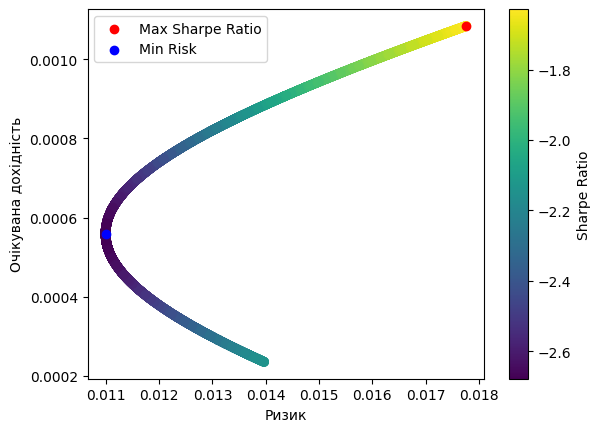

In [ ]:
plt.scatter(portfolios_df['Risk'], portfolios_df['Return'], c=portfolios_df['Sharpe'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_portfolio['Risk'], max_sharpe_portfolio['Return'], color='red', label='Max Sharpe Ratio')
plt.scatter(min_risk_portfolio['Risk'], min_risk_portfolio['Return'], color='blue', label='Min Risk')
plt.xlabel('Ризик')
plt.ylabel('Очікувана дохідність')
plt.legend()
plt.show()

In [ ]:
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [ ]:
def optimize_portfolio(target_return, mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    w = cp.Variable(num_assets)
    risk = cp.quad_form(w, cov_matrix)
    objective = cp.Minimize(risk)

    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        mean_returns @ w >= target_return
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return w.value, np.sqrt(risk.value)

In [ ]:
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
efficient_frontier = []

for target in target_returns:
    weights, risk = optimize_portfolio(target, mean_returns.values, cov_matrix.values)
    efficient_frontier.append((risk, target))

efficient_frontier = np.array(efficient_frontier)

In [ ]:
print(efficient_frontier)

[[0.0129233  0.00017125]
 [0.0129233  0.00018969]
 [0.0129233  0.00020813]
 [0.0129233  0.00022657]
 [0.0129233  0.00024501]
 [0.0129233  0.00026345]
 [0.0129233  0.00028189]
 [0.0129233  0.00030033]
 [0.0129233  0.00031877]
 [0.0129233  0.00033721]
 [0.0129233  0.00035564]
 [0.0129233  0.00037408]
 [0.0129233  0.00039252]
 [0.0129233  0.00041096]
 [0.0129233  0.0004294 ]
 [0.0129233  0.00044784]
 [0.01292809 0.00046628]
 [0.01294285 0.00048472]
 [0.01296754 0.00050316]
 [0.0130021  0.0005216 ]
 [0.01304646 0.00054004]
 [0.01310052 0.00055848]
 [0.01316415 0.00057692]
 [0.01323722 0.00059536]
 [0.01331958 0.0006138 ]
 [0.01341104 0.00063224]
 [0.01351144 0.00065068]
 [0.01362056 0.00066912]
 [0.01373821 0.00068756]
 [0.01386416 0.000706  ]
 [0.01399819 0.00072444]
 [0.01414007 0.00074288]
 [0.01428957 0.00076132]
 [0.01444646 0.00077976]
 [0.01461048 0.0007982 ]
 [0.01478141 0.00081664]
 [0.014959   0.00083508]
 [0.01514304 0.00085352]
 [0.01533327 0.00087196]
 [0.01552948 0.0008904 ]


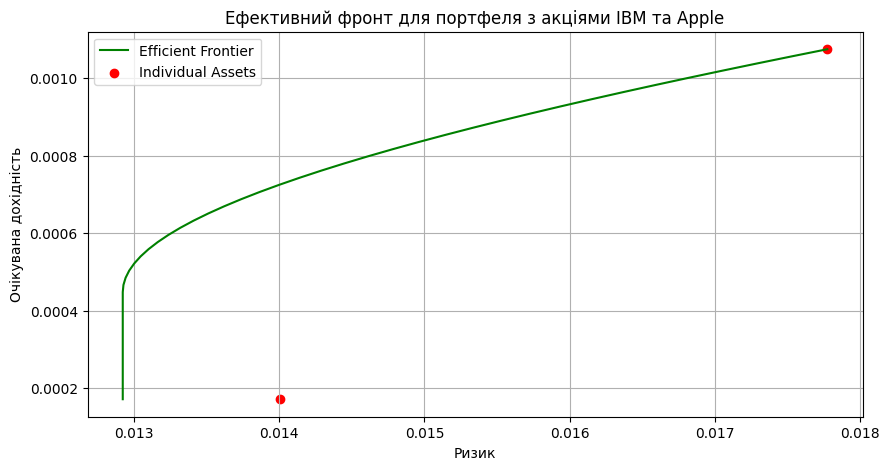

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(efficient_frontier[:, 0], efficient_frontier[:, 1], label='Efficient Frontier', color='green')
plt.scatter(np.sqrt(np.diag(cov_matrix)), mean_returns, label='Individual Assets', color='red')
plt.title('Ефективний фронт для портфеля з акціями IBM та Apple')
plt.xlabel('Ризик')
plt.ylabel('Очікувана дохідність')
plt.legend()
plt.grid(True)
plt.show()